# Plot the Download and Contributor Statistics

## Imports

In [1]:
from condastats.cli import overall, pkg_platform, pkg_version, pkg_python, data_source
import s3fs
import pandas as pd
import matplotlib.pyplot as plt

## Download Stats for Py-ART

### Conda

In [125]:
df = overall('arm_pyart',
             start_month='2019-01',
             end_month='2023-01',
             monthly=True)['arm_pyart']

### Cleanup the Data

In [27]:
df.index = pd.to_datetime(df.index)
conda_downloads = df

### PyPi

In [36]:
pypi = pd.read_csv("../data/pypi_stats.csv",
                   parse_dates=True,
                   index_col='month')

In [37]:
pypi_downloads = pypi["arm-pyart"]

### Visualize the Results

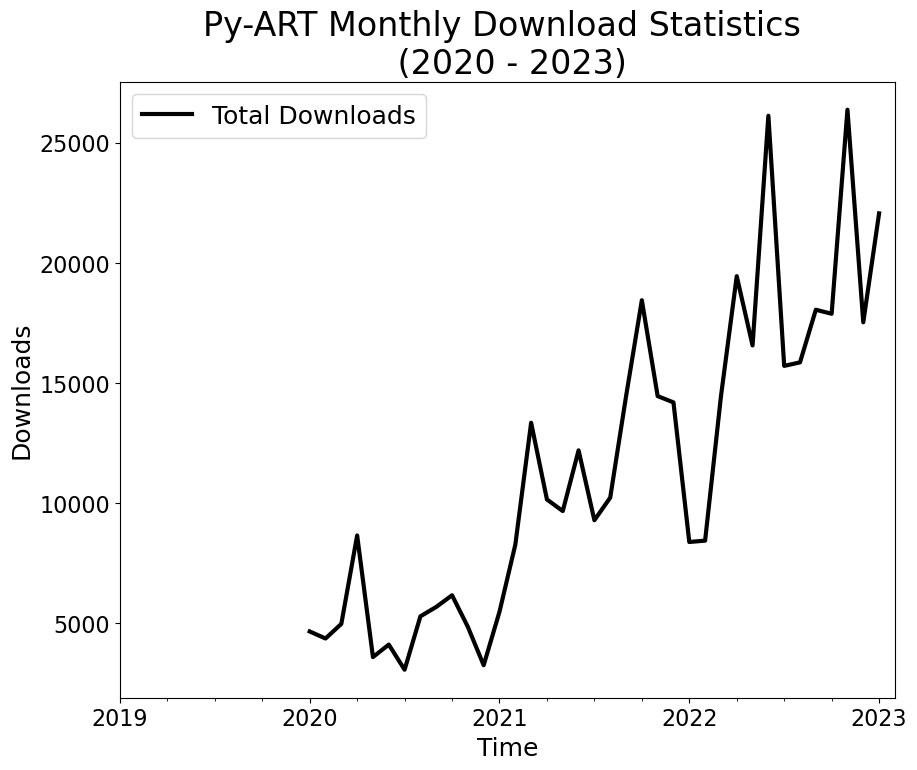

In [115]:
fig = plt.figure(figsize=(10,8))
(pypi_downloads + conda_downloads).plot(linewidth=3, color='black', label='Total Downloads')
#conda_downloads.plot(linewidth=3, label='conda downloads')
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Downloads", fontsize=18)
plt.title("Py-ART Monthly Download Statistics \n (2020 - 2023)",
          fontsize=24);
plt.savefig("monthly_download_stats_through_january_2023.png", dpi=300, transparent=False, facecolor='white')

## Commit History

In [39]:
df = pd.read_csv("../data/github_commits.csv",
                 index_col='date',
                 parse_dates=True)

In [70]:
INTERNAL_AUTHORS = set(['zssherman',
                        'rcjackson',
                        'scollis',
                        'mgrover1',
                        'jhemedin',
                        'AdamTheisen',
                        'jrobrien91'])
def get_commits_data():
    def author_type(author):
        if author in INTERNAL_AUTHORS:
            return 'Internal'
        elif '[bot]' in str(author):
            return None
        else:
            return 'External'

    df = pd.read_csv('../data/github_commits.csv', index_col='date', parse_dates=True) \
           .sort_index() \
           .tz_localize(None)
    df['changes'] = df.additions + df.deletions
    df['author_type'] = df.author.apply(author_type)
    df = df.drop(columns=['additions', 'deletions'])
    return df

In [127]:
df = get_commits_data()

In [128]:
df_c = df

In [129]:
df['date'] = pd.to_datetime(df.index)

In [130]:
df = df.loc[df.package == 'pyart']
df.groupby([df['date'].dt.year, 'author']).count()

package  changes  author_type  date
date author                                              
2012 scollis              124      124          124   124
2013 jjhelmus             353      353          353   353
     josephhardinee        10       10           10    10
     kirknorth              1        1            1     1
     kmuehlbauer            5        5            5     5
     scollis               87       87           87    87
     vanandel               2        2            2     2
2014 codypiersall           1        1            1     1
     jjhelmus             186      186          186   186
     josephhardinee         3        3            3     3
     kirknorth             22       22           22    22
     scollis               13       13           13    13
2015 WeatherGod             1        1            1     1
     deeplycloudy           3        3            3     3
     gamaanderson          38       38           38    38
     jjhelmus             576      576          576   576
     josephhardinee         4        4            4     4
     kirknorth             10       10           10    10
     nguy                   7        7            7     7
     scollis               15       15           15    15
     swnesbitt              1        1            1     1
     tjlang                 5        5            5     5
2016 TulipaSilva            2        2            2     2
     jjhelmus             315      315          315   315
     jsignell               8        8            8     8
     kirknorth             19       19           19    19
     kmuehlbauer            5        5            5     5
     mrugna                 2        2            2     2
     nguy                  17       17           17    17
     normbw                 1        1            1     1
     scollis               24       24           24    24
     swnesbitt              8        8            8     8
     tjlang                13       13           13    13
2017 freemansw1             4        4            4     4
     jjhelmus              21       21           21    21
     rcjackson             11       11           11    11
     scollis               17       17           17    17
     swnesbitt              1        1            1     1
     tjlang                10       10           10    10
     vlouf                  7        7            7     7
     zssherman             11       11           11    11
2018 Striges                1        1            1     1
     csnardi                1        1            1     1
     es5nhc                 1        1            1     1
     gamaanderson           2        2            2     2
     jhemedin              13       13           13    13
     juhi24                 1        1            1     1
     kmuehlbauer            2        2            2     2
     mhpicel                1        1            1     1
     nguy                   1        1            1     1
     rcjackson             23       23           23    23
     rtanamachi             2        2            2     2
     scollis               76       76           76    76
     tjlang                 3        3            3     3
     vlouf                  3        3            3     3
     wave100                4        4            4     4
     zssherman            101      101          101   101
     zxdawn                 1        1            1     1
2019 AdamTheisen            1        1            1     1
     dstex                  1        1            1     1
     jhemedin              16       16           16    16
     meteoswiss-mdr         1        1            1     1
     nguy                   1        1            1     1
     rcjackson              6        6            6     6
     scollis               22       22           22    22
     tjlang                 2        2            2     2
     zssherman             92       92           92    92
2020 AdamTheisen    

In [132]:
def cumsum_unique_authors(data):
        data['authors'] = data['authors'].cumsum().map(set).map(len)
        return data

def make_contributor_images(df_c: pd.DataFrame):

    df_c = df_c.drop(columns='changes').dropna()
    idx = pd.MultiIndex.from_product([
    pd.period_range(start=df_c.index.min(), end=df_c.index.max(), freq='M'),
    df_c.package.unique(),
    df_c.author_type.unique(),
], names=['month', 'package', 'author_type'])
df_c = df_c.groupby([df_c.index.to_period('M'), 'package', 'author_type']) \
           .agg(list) \
           .rename(columns={'author': 'authors'}) \
           .reindex(idx, fill_value=[]) \
           .reset_index(['package', 'author_type']) \
           .groupby(['package', 'author_type']) \
           .apply(cumsum_unique_authors)

for pkg in df_c.package.unique():
    df = df_c.loc[df_c.package == pkg] \
             .drop(columns='package') \
             .reset_index() \
             .pivot(index='month', columns='author_type', values='authors') \
             .astype('int64')
    filename = f'images/metrics/{pkg}-contributors.html'
    title = 'Number of Contributors'
   # _make_stacked_bar_plot(df, filename, title, 'Contributors')

/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/ipykernel_11999/4001969942.py:19: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(cumsum_unique_authors)


### Visualize the Data

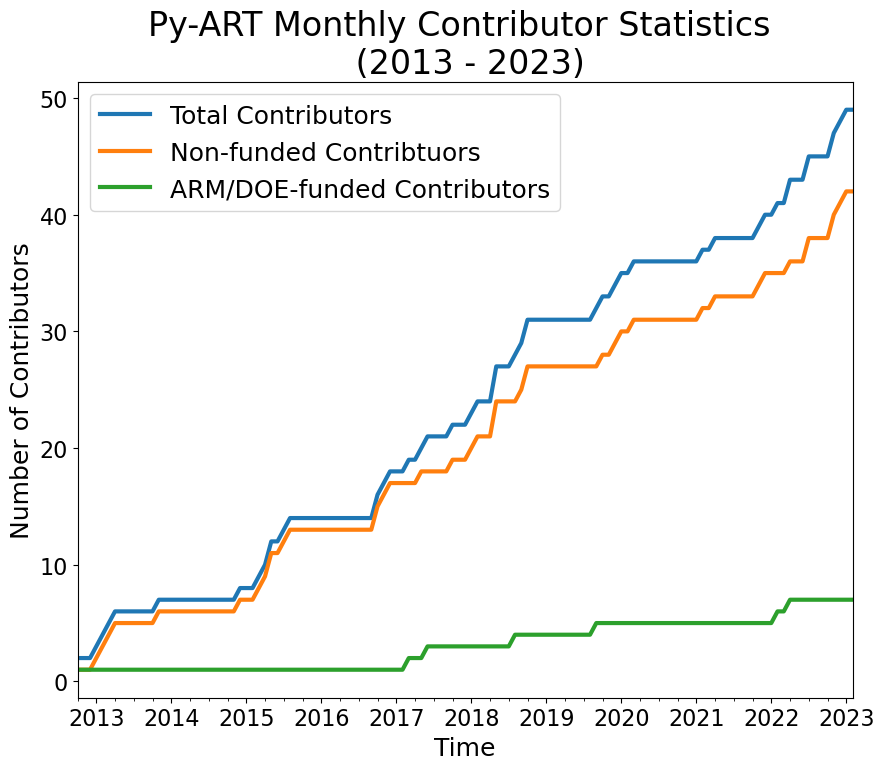

In [124]:
fig = plt.figure(figsize=(10,8))
(df.Internal + df.External).plot.line(linewidth=3,
                                      label='Total Contributors')
df.External.plot.line(linewidth=3,
                      label='Non-funded Contribtuors')
df.Internal.plot.line(linewidth=3,
                      label='ARM/DOE-funded Contributors')
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Number of Contributors", fontsize=18)
plt.title("Py-ART Monthly Contributor Statistics \n (2013 - 2023)",
          fontsize=24);
plt.legend(fontsize=18)
plt.savefig("monthly_contributor_stats_through_january_2023.png",
            dpi=300,
            transparent=False,
            facecolor='white');